Import package
=====================

In [ ]:
pip install pytorch-nlp

In [ ]:
import torch
from torchnlp.word_to_vector import GloVe
from torch import nn, optim
import matplotlib.pyplot as plt
from collections import OrderedDict
from torch.autograd.variable import Variable
import seaborn as sns
import numpy as np

Import dataset
=========================

In [ ]:
numwords = 50000
max = 200
from tensorflow.keras.datasets import imdb
(X_train_numpy, Y_train_numpy), (X_test_numpy, Y_test_numpy) \
= imdb.load_data(num_words=numwords, seed=500)
word2id = imdb.get_word_index()
id2word = {i: word for word, i in word2id.items() if i < numwords}

1646592/1641221 [==============================] - 0s 0us/step


In [ ]:
# Y_train = torch.from_numpy(Y_train_numpy).type(torch.float)
# Y_test = torch.from_numpy(Y_test_numpy).type(torch.float)
Y_train = torch.from_numpy(Y_train_numpy).type(torch.float).cuda()
Y_test = torch.from_numpy(Y_test_numpy).type(torch.float).cuda()
print(f"Y_train is {Y_train.size()}, Y_test is {Y_test.size()}")

Y_train is torch.Size([25000]), Y_test is torch.Size([25000])


remove stop words and trivial words
------------------------------------------
first we get id of all stop words

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
print(stop_words)
stop_words_id = [word2id.get(i, 0) for i in stop_words]
print(stop_words_id)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'ea

remove stop words on train and test set

In [ ]:
# remove stop words on train set
X_train_numpy_rm_stopwords = []
for comment in X_train_numpy:
    X_train_numpy_rm_stopwords.append([w for w in comment if w not in stop_words_id])
    # print([w for w in comment if w not in stop_words_id])
X_train_numpy_rm_stopwords = np.array(X_train_numpy_rm_stopwords)

# remove stop words on test set
X_test_numpy_rm_stopwords = []
for comment in X_test_numpy:
    X_test_numpy_rm_stopwords.append([w for w in comment if w not in stop_words_id])
    # print([w for w in comment if w not in stop_words_id])
X_test_numpy_rm_stopwords = np.array(X_test_numpy_rm_stopwords)

remove trivial words ```['br', 'movie', 'film', 'one', 'character', 'movies']```

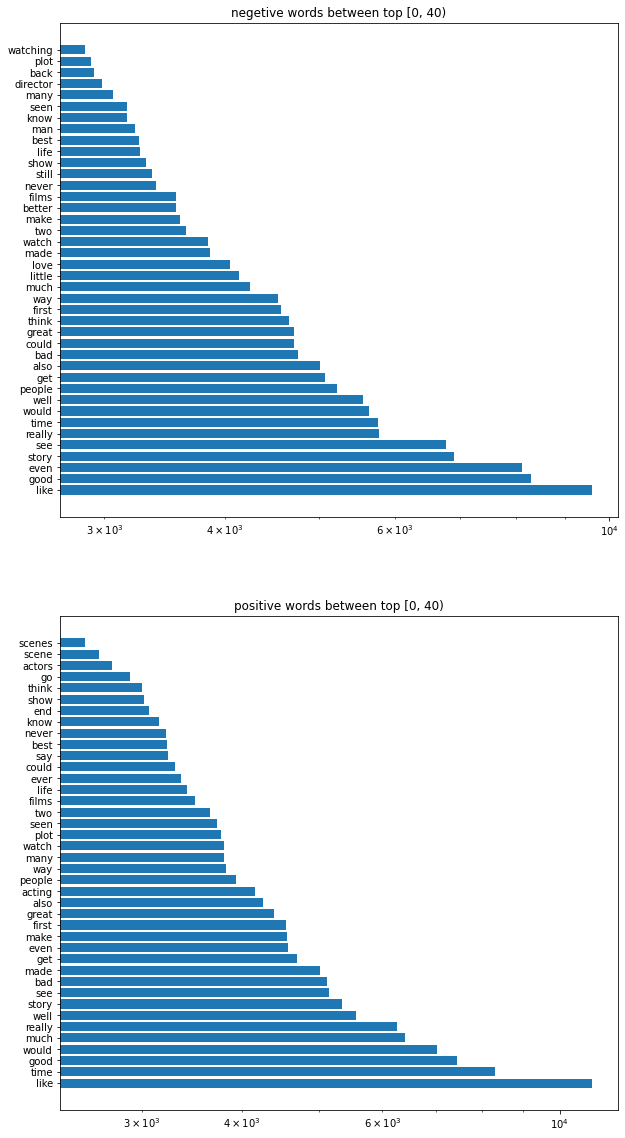

In [ ]:
# define trivial words
trivial_words_id = [word2id.get(i, 0) for i in ['br', 'movie', 'film', 'one', 'character', 'movies', 'characters']]

# remove trivial words on train set
X_train_numpy_clean = []
for comment in X_train_numpy_rm_stopwords:
    X_train_numpy_clean.append([w for w in comment if w not in trivial_words_id])
    # print([w for w in comment if w not in stop_words_id])
X_train_numpy_clean = np.array(X_train_numpy_clean)

# remove trivial words on test set
X_test_numpy_clean = []
for comment in X_test_numpy_rm_stopwords:
    X_test_numpy_clean.append([w for w in comment if w not in trivial_words_id])
    # print([w for w in comment if w not in stop_words_id])
X_test_numpy_clean = np.array(X_test_numpy_clean)

# word frequency on train set
neg_word_freq = {}
pos_word_freq = {}
for comment_id, comment in enumerate(X_train_numpy_clean):
    if Y_train_numpy[comment_id] == 0: # this comment is negative
        for w in comment:
            neg_word_freq[w] = neg_word_freq.get(w, 0) + 1
    elif Y_train_numpy[comment_id] == 1: # this comment is positive
        for w in comment:
            pos_word_freq[w] = pos_word_freq.get(w, 0) + 1

# sort them
neg_word_freq_sort = sorted(neg_word_freq.items(), key=lambda x: x[1], reverse=True)
pos_word_freq_sort = sorted(pos_word_freq.items(), key=lambda x: x[1], reverse=True)

# plot
(low_bd, high_bd) = (0, 40)
neg = [(id2word[item[0]], item[1]) for i, item in enumerate(neg_word_freq_sort) if i < high_bd and i >= low_bd]
pos = [(id2word[item[0]], item[1]) for i, item in enumerate(pos_word_freq_sort) if i < high_bd and i >= low_bd]

plt.figure(figsize=(10,20))
plt.subplot(2, 1, 1)
plt.barh([x[0] for x in neg], [x[1] for x in neg], log=True)
plt.title(f"negetive words between top [{low_bd}, {high_bd})")
plt.subplot(2, 1, 2)
plt.barh([x[0] for x in pos], [x[1] for x in pos], log=True)
plt.title(f"positive words between top [{low_bd}, {high_bd})")
plt.show()

Import Glove
======================= 

In [ ]:
glove = GloVe(name='6B', dim=50)

In [ ]:
glove[',jalgja']

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])

RNN1
=========================
input_size = the length of word2vec  
hidden_size = casual  

hidden = concat(input, hidden) * H + b  
output = hidden * V + c

In [ ]:
class RNN1(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout=0):
        super(RNN1, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.hidden_size = hidden_size
        self.i2h = nn.Sequential(
            nn.Linear(input_size + hidden_size, hidden_size))
        self.i2o = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size, output_size),
            nn.Sigmoid())
        self.tanh = nn.Tanh()

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 0)
        hidden = self.tanh(self.i2h(combined))
        output = self.i2o(hidden)
        
        return hidden, output

    def initHidden(self):
        return torch.zeros(self.hidden_size)

Logistic Regression
========================

In [ ]:
class Logistic(nn.Module):
    def __init__(self):
        super(Logistic, self).__init__()
        self.linear = nn.Linear(1, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.sigmoid(self.linear(x))
        return x

Implement
=================

hidden layer = 20 (take final output)
--------------------
train

epoch is 0, acc_rate is 0.5, loss is 0.18060176074504852



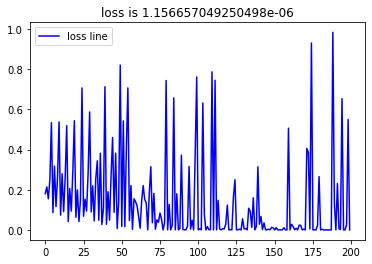

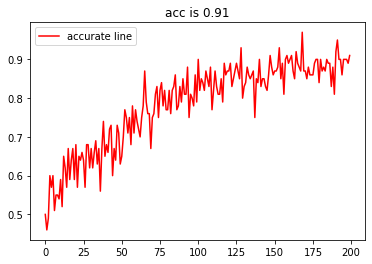

In [27]:
from tqdm.notebook import tnrange, tqdm_notebook


rnn1 = RNN1(50, 20, 1, 0.2).cuda()
# lr1 = Logistic().cuda()
rnn1_optimizer = optim.SGD(rnn1.parameters(), lr = 0.01, momentum=0.9)
# lr1_optimizer = optim.SGD(lr1.parameters(), lr = 0.001, momentum=0.9)

# loss function
loss_function = nn.MSELoss()

# init acc
acc = 0


batch_size = 100

# list
epoch_list = []
loss_list = []
acc_rate_list = []

for ep in tnrange(200):

    acc = 0

    # X_train_numpy_segment = X_train_numpy[ep * batch_size : (ep + 1) * batch_size]
    # Y_train_segment = Y_train[ep * batch_size : (ep + 1) * batch_size]

    for i in range(batch_size):

        # initial hidden layer
        hidden_layer = rnn1.initHidden().cuda()
        # initial learnable parameters
        rnn1.zero_grad()

        t = (ep * batch_size + i) % 250
        
        for word in [id2word[id] for (i, id) in enumerate(X_train_numpy_clean[t]) if i < 80]:

            # get word embedding
            wordEmbedding = glove[word].cuda()

            # forward
            hidden_layer, output_layer = rnn1(wordEmbedding, hidden_layer.detach())
        
        # put final output through logistic regression
        # out = lr1(output_layer)
        loss = loss_function(output_layer, Y_train[t].view(1))
        # print(f"pred: {output_layer.item()}, real: {Y_train[t].view(1).item()}")
        loss.backward()
        rnn1_optimizer.step()

        # calculate accurate rate
        pred = np.round(output_layer.cpu().detach().numpy())
        if pred[0] == Y_train[t].cpu().detach().numpy():
            acc += 1
    
    acc_rate = acc / batch_size
    if ep % 500 == 0:
        print(f"epoch is {ep}, acc_rate is {acc_rate}, loss is {loss.item()}")

    epoch_list.append(ep)
    loss_list.append(loss.item())
    acc_rate_list.append(acc_rate)

fig, ax = plt.subplots()
sns.lineplot(x=epoch_list, y=loss_list, color='blue', label='loss line', ax=ax)
plt.title(f"loss is {loss.item()}")
plt.show()

fig, ax = plt.subplots()
sns.lineplot(x=epoch_list, y=acc_rate_list, color='red', label='accurate line', ax=ax)
plt.title(f"acc is {acc_rate}")
plt.show()

test

In [28]:
acc = 0
for i in tnrange(150):

    hidden_layer = rnn1.initHidden().cuda()
    
    for word in [id2word[id] for id in X_test_numpy_clean[i]]:

        # get word embedding
        wordEmbedding = glove[word].cuda()

        # forward
        hidden_layer, output_layer = rnn1(wordEmbedding, hidden_layer)
    
    # put final output through logistic regression

    # calculate accurate rate
    pred = np.round(output_layer.cpu().detach().numpy())
    if pred[0] == Y_test[i].cpu().detach().numpy():
        acc += 1

acc_rate = acc / 150
print(f"acc_rate is {acc_rate}")


acc_rate is 0.5
